In [1]:
import logging
import os
import pickle

import wandb
import datasets
import torch
import numpy as np
from dotenv import dotenv_values
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from transformers import pipeline, AutoImageProcessor, AutoModel
from transformers.image_processing_base import BatchFeature
from scipy.cluster.hierarchy import dendrogram

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device = "cuda:5"

if 'notebooks' in os.getcwd():
    os.chdir("../")

In [2]:
local_config = dotenv_values(".env")

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "concept-generation",
    },
    save_code=False,
)

wandb: Currently logged in as: nhathcmus to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
%load_ext autoreload
%autoreload 2
from exrep.registry import load_hf_dataset, save_tensor, load_entry, save_file, save_pickle, get_artifact
from exrep.utils import generic_map

alias = 'latest'

crops_dataset = load_hf_dataset(
    base_name="imagenet",
    phase="crops",
    alias=alias,
    wandb_run=run,
).with_format('numpy')

offset = np.max(crops_dataset['train']['image_id']) + 1
crops_dataset['validation'] = crops_dataset['validation'].map(
    lambda x: {
        "image_id": [y + offset for y in x["image_id"]]
    },    
    batched=True,
    keep_in_memory=True,
)

combined_crops_dataset = datasets.concatenate_datasets([crops_dataset['train'], crops_dataset['validation']], axis=0)
num_images = max(combined_crops_dataset["image_id"]) + 1

logger.info(f"Number of images: {num_images}")

wandb: Downloading large artifact imagenet-1k-first-20-take-2000_crops:latest, 510.63MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.7


Map:   0%|          | 0/4208 [00:00<?, ? examples/s]

INFO:__main__:Number of images: 3000


In [4]:
# we either compute the clustering or load it from disk
load_clustering = False

def perform_clustering(dataset):
    processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
    model = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
    dataloader = torch.utils.data.DataLoader(
        dataset.with_transform(lambda x: processor(images=x['patches'], return_tensors="pt")), 
        batch_size=128
    )
    embeddings = generic_map(
        model,
        dataloader,
        post_proc_fn=lambda x: x.pooler_output,
        input_format="keyword",
        device=device
    )
    logger.info("Embeddings shape: %s", embeddings.shape)

    clustering = AgglomerativeClustering(n_clusters=1, metric='euclidean', compute_distances=True).fit(embeddings.cpu().numpy())
    return clustering

if not load_clustering:
    clustering = perform_clustering(combined_crops_dataset)
    with open("outputs/clustering.pkl", "wb") as f:
        pickle.dump(clustering, f)
    
    save_file(
        base_name="imagenet",
        phase="clustering",
        type="scikit-clustering",
        file_path="outputs/clustering.pkl",
        file_name="agglomerative.pkl",
        mode='write-new',
        alias=alias,
        wandb_run=run,
    )
else:
    clustering_pkl = load_entry(
        artifact_name="imagenet-1k-first-20-take-2000_clustering",
        file_name="agglomerative.pkl",
        wandb_run=run,
    )
    with open(clustering_pkl, "rb") as f:
        clustering = pickle.load(f)
dendograms = {}

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 92/92 [01:03<00:00,  1.45it/s]
INFO:__main__:Embeddings shape: torch.Size([11697, 768])
INFO:exrep.registry:Creating artifact imagenet-1k-first-20-take-2000_clustering:latest on wandb


In [5]:
from exrep.viz import plot_dendrogram, get_cluster_leaves, get_cluster_children

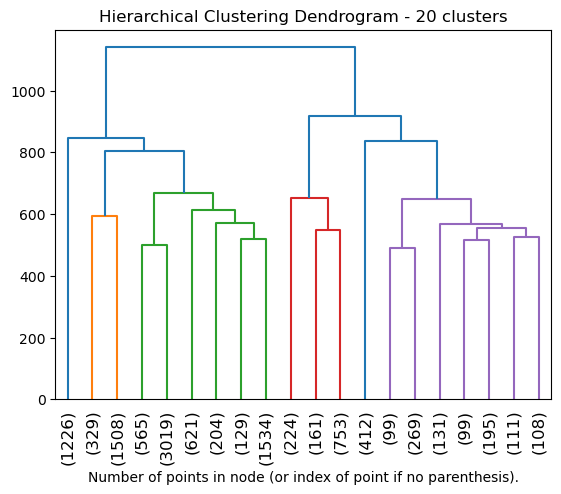

In [6]:
clusters_to_compute = [20, 40, 80, 160, 320]
clusters_to_viz = clusters_to_compute[0]

for n_clusters in clusters_to_compute:
    if n_clusters not in dendograms:
        dendograms[n_clusters] = plot_dendrogram(
            clustering, truncate_mode="lastp", p=n_clusters, leaf_rotation=90, 
            no_plot=n_clusters!=clusters_to_viz
        )

plt.title(f"Hierarchical Clustering Dendrogram - {clusters_to_viz} clusters")
# plot the top three levels of the dendrogram
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [7]:
from typing import Sequence
from sklearn.preprocessing import LabelEncoder

def compute_local_encoding(
    cluster_ids: Sequence[int],
    clustering,
    crop_to_image_indices: np.array,
    n_images: int,
    min_cluster_size=5,
):
    cluster_labels, _ = get_cluster_leaves(cluster_ids, clustering)
    # filter out clusters with less than min_cluster_size elements
    cluster_indices = {}
    for i in cluster_ids:
        crop_indices = np.where(cluster_labels == i)[0]
        image_indices = np.unique(crop_to_image_indices[crop_indices]).astype(int)
        if len(image_indices) >= min_cluster_size:
            cluster_indices[i] = image_indices

    label_encoder = LabelEncoder().fit(list(cluster_indices.keys()))
    local_encoding = np.zeros((n_images, label_encoder.classes_.shape[0]))
    normalized_ids = label_encoder.transform(list(cluster_indices.keys()))
    for i, indices in zip(normalized_ids, cluster_indices.values()):
        local_encoding[indices, i] = 1
    return local_encoding, label_encoder

artifact = get_artifact(
    base_name="imagenet",
    phase="local-encoding",
    identifier=f"agglomerative",
    type="torch_tensor",
    metadata={
        "objective": "ward",
    },
    alias=alias,
    mode='write-new',
    wandb_run=run,
)
for n_clusters in clusters_to_compute:
    local_encoding, label_encoder = compute_local_encoding(
        cluster_ids=dendograms[n_clusters]['leaves'],
        clustering=clustering,
        crop_to_image_indices=np.array(combined_crops_dataset['image_id']),
        n_images=num_images,
    )
    
    local_encoding = torch.from_numpy(local_encoding)
    train_encoding = local_encoding[:offset]
    val_encoding = local_encoding[offset:]
    logger.info("Train encoding has shape %s and sum %s", train_encoding.shape, train_encoding.sum().item())
    logger.info("Validation encoding has shape %s and sum %s", val_encoding.shape, val_encoding.sum().item())

    artifact = save_tensor(
        train_encoding,
        file_name=f"local-encoding-{n_clusters}_train.pt",
        artifact=artifact,
        mode='readonly',
        finalize=False,
    )
    artifact = save_tensor(
        val_encoding,
        file_name=f"local-encoding-{n_clusters}_validation.pt",
        artifact=artifact,
        mode='readonly',
        finalize=False,
    )
    artifact = save_pickle(
        label_encoder,
        file_name=f"label-encoder-{n_clusters}.pkl",
        artifact=artifact,
        mode='readonly',
        finalize=False,
    )
run.log_artifact(artifact)

INFO:exrep.registry:Creating artifact imagenet-1k-first-20-take-2000_local-encoding_agglomerative:latest on wandb
INFO:__main__:Train encoding has shape torch.Size([2000, 20]) and sum 4741.0
INFO:__main__:Validation encoding has shape torch.Size([1000, 20]) and sum 2568.0
INFO:__main__:Train encoding has shape torch.Size([2000, 40]) and sum 5542.0
INFO:__main__:Validation encoding has shape torch.Size([1000, 40]) and sum 3055.0
INFO:__main__:Train encoding has shape torch.Size([2000, 80]) and sum 6016.0
INFO:__main__:Validation encoding has shape torch.Size([1000, 80]) and sum 3355.0
INFO:__main__:Train encoding has shape torch.Size([2000, 159]) and sum 6272.0
INFO:__main__:Validation encoding has shape torch.Size([1000, 159]) and sum 3493.0
INFO:__main__:Train encoding has shape torch.Size([2000, 309]) and sum 6454.0
INFO:__main__:Validation encoding has shape torch.Size([1000, 309]) and sum 3605.0


<Artifact imagenet-1k-first-20-take-2000_local-encoding_agglomerative>

In [8]:
wandb.finish()